In [1]:
# cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import os
import random

import clip
import vgg
import transformer
import utils


# Option 1: style image
![style image](images\\starry_night_clone_small_256.jpg "style")

In [ ]:
# cell 2: Config
DATASET_PATH = '../../datasets/coco2017'#E:/Documenti/Datasets/COCO2017/images'
STYLE_IMAGE_PATH = 'images/starry_night_clone_small_256.jpg'
SAVE_MODEL_PATH = 'checkpoints/starry256_a100/model/'
SAVE_IMAGE_PATH = 'checkpoints/starry256_a100/images/'

NUM_EPOCHS = 2
PRETRAIN_BATCHES = 500
TRAIN_IMAGE_SIZE = 196
STYLE_SCALES = 1
STYLE_DOWNSAMPLE = 0
STYLE_WEIGHT = 10
CONTENT_WEIGHT = 1e-4
VARIATION_WEIGHT = 1e-3
CLIP_WEIGHT = 2
COLOR_WEIGHT = 2e2
MSE_WEIGHT = 1e-3
ALPHA = 1.00
BN_INSTEAD_OF_IN = True
BATCH_SIZE = 4
SEED = 11
ADAM_LR = 1e-3
CONTENT_LAYER = 'relu4_4'
CLIP_IMG_SZ = 224
STYLE_WEIGHTS_DICT = {'relu1_2': 1, 'relu2_2': 1, 'relu3_4': 1, 'relu4_2': 1, 'relu4_4': 1, 'relu5_4': 1}
SAVE_MODEL_EVERY = 500


# Option 2: style image
![style image](images\\spaghetti.jpg "style")

In [2]:
# cell 2: Config
DATASET_PATH = '../../datasets/coco2017'#E:/Documenti/Datasets/COCO2017/images'
STYLE_IMAGE_PATH = 'images/spaghetti.jpg'
SAVE_MODEL_PATH = 'models/spaghetti256_a75/model/'
SAVE_IMAGE_PATH = 'models/spaghetti256_a75/images/'

NUM_EPOCHS = 2
PRETRAIN_BATCHES = 500
TRAIN_IMAGE_SIZE = 196
STYLE_SCALES = 1
STYLE_DOWNSAMPLE = 1
STYLE_WEIGHT = 3
CONTENT_WEIGHT = 3e-4
VARIATION_WEIGHT = 1e-3
CLIP_WEIGHT = 2
COLOR_WEIGHT = 1e1
MSE_WEIGHT = 1e-4
ALPHA = 0.75
BN_INSTEAD_OF_IN = True
BATCH_SIZE = 4
SEED = 11
ADAM_LR = 1e-3
CONTENT_LAYER = 'relu4_4'
CLIP_IMG_SZ = 224
STYLE_WEIGHTS_DICT = {'relu1_2': 1, 'relu2_2': 1, 'relu3_4': 1, 'relu4_2': 1, 'relu4_4': 1, 'relu5_4': 1}
SAVE_MODEL_EVERY = 500


# Option 3: style image
![style image](images\\picasso_muse_256.jpg "style")

In [ ]:
# cell 2: Config
DATASET_PATH = '../../datasets/coco2017'
STYLE_IMAGE_PATH = 'images/picasso_muse_256.jpg'
SAVE_MODEL_PATH = 'checkpoints/muse_bn_a75/model/'
SAVE_IMAGE_PATH = 'checkpoints/muse_bn_a75/images/'

NUM_EPOCHS = 2
PRETRAIN_BATCHES = 500 #2000
TRAIN_IMAGE_SIZE = 256
STYLE_SCALES = 1
STYLE_DOWNSAMPLE = 0
STYLE_WEIGHT = 5
CONTENT_WEIGHT = 1e-4
VARIATION_WEIGHT = 1e-3
CLIP_WEIGHT = 2
COLOR_WEIGHT = 2e2
MSE_WEIGHT = 1e-3
ALPHA = 0.75
BN_INSTEAD_OF_IN = True
BATCH_SIZE = 4
SEED = 11
ADAM_LR = 1e-3
CONTENT_LAYER = 'relu4_4'
CLIP_IMG_SZ = 224
STYLE_WEIGHTS_DICT = {'relu1_2': 1, 'relu2_2': 1, 'relu3_4': 1, 'relu4_2': 1, 'relu4_4': 1, 'relu5_4': 1}
SAVE_MODEL_EVERY = 500


In [3]:
# cell 3: Setup
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(TRAIN_IMAGE_SIZE),
    transforms.CenterCrop(TRAIN_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

transform_clip = transforms.Compose([
    transforms.Resize(CLIP_IMG_SZ),
    transforms.Lambda(lambda x: x.div(255.0)),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)

train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_PATH, exist_ok=True)


In [4]:
# cell 4: Load models
TransformerNetwork = transformer.TransformerNetworkXiNet(alpha=ALPHA, lite=False, num_pool=STYLE_SCALES-1, bn_instead_of_in=BN_INSTEAD_OF_IN).to(device)
VGG = vgg.VGG19().to(device)
CLIP_NET, _ = clip.load('RN50', device)
CLIP_NET.eval().float()
CLIP_NET.requires_grad_(False)

intermediate_tensor = None
def hook_fn(module, input, output):
    global intermediate_tensor
    intermediate_tensor = output.clone()

CLIP_NET.visual.layer4.register_forward_hook(hook_fn)


layer                                     name  gradient   parameters                shape         mu      sigma
    0      ConvBlock.0.compression_conv.weight      True            9         [3, 3, 1, 1]    -0.0191      0.332
    1             ConvBlock.0.main_conv.weight      True         2916        [12, 3, 9, 9]   0.000431     0.0365
    2                    ConvBlock.0.bn.weight      True           12                 [12]          1          0
    3                      ConvBlock.0.bn.bias      True           12                 [12]          0          0
    4      ConvBlock.1.compression_conv.weight      True          144       [12, 12, 1, 1]   -0.00307      0.169
    5             ConvBlock.1.main_conv.weight      True         5184       [48, 12, 3, 3]  -0.000478      0.056
    6                    ConvBlock.1.bn.weight      True           48                 [48]          1          0
    7                      ConvBlock.1.bn.bias      True           48                 [48]      

c:\Users\ancil\anaconda3\envs\pt25\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ancil\anaconda3\envs\pt25\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\ancil\Documents\Code\XiNet_style_transfer_github\vgg.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weight

In [5]:
# cell 5: Style image
style_grams = []

for style_id in range(STYLE_SCALES):
    style_tensor = utils.itot(utils.load_image(STYLE_IMAGE_PATH), scale=True).to(device)
    style_tensor = style_tensor.add(imagenet_neg_mean)
    style_tensor = nn.functional.avg_pool2d(style_tensor, 2**(style_id + STYLE_DOWNSAMPLE))
    B, C, H, W = style_tensor.shape
    features = VGG(style_tensor.expand([BATCH_SIZE, C, H, W]))
    style_gram = {k: utils.scale(utils.gram(v)) for k, v in features.items()}
    style_grams.append(style_gram)


In [6]:
# cell 6: Loss computation
def total_variation_loss(img):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
    tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
    return (tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

def color_loss(generated, original):
    assert generated.shape == original.shape, "Content and style images must have the same shape."

    original_ycbcr = utils.rgb2ycbcr(torch.clamp(original/255.0, 0, 1))
    generated_ycbcr = utils.rgb2ycbcr(torch.clamp(generated/255.0, 0, 1))

    original_cb, original_cr = original_ycbcr[:, 1, :, :], original_ycbcr[:, 2, :, :]
    generated_cb, generated_cr = generated_ycbcr[:, 1, :, :], generated_ycbcr[:, 2, :, :]

    mse_cb = F.mse_loss(original_cb, generated_cb)
    mse_cr = F.mse_loss(original_cr, generated_cr)

    total_color_loss = mse_cb + mse_cr

    return total_color_loss

def clip_loss(content_batch, generated_batch, clip_net, transform_clip):
    content_clip = transform_clip(content_batch)
    gen_clip = transform_clip(generated_batch)
    clip_feat_c = clip_net.encode_image(content_clip)
    clip_feat_g = clip_net.encode_image(gen_clip)
    return (1 - torch.cosine_similarity(clip_feat_c, clip_feat_g).mean())

def style_loss(generated_batches, style_grams, STYLE_WEIGHT, STYLE_WEIGHTS_DICT):
    MSELoss = nn.MSELoss()
    total_style_loss = 0
    for scale_id, generated in enumerate(generated_batches):
        features = VGG(generated.add(imagenet_neg_mean))
        for layer, weight in STYLE_WEIGHTS_DICT.items():
            target_gram = utils.scale(style_grams[scale_id][layer])
            generated_gram = utils.scale(utils.gram(features[layer]))
            total_style_loss += STYLE_WEIGHT * weight * MSELoss(generated_gram, target_gram)
    return total_style_loss

def content_loss(content_batch, generated_batch, vgg, layer):
    MSELoss = nn.MSELoss()
    content_features = vgg(content_batch.add(imagenet_neg_mean))
    generated_features = vgg(generated_batch.add(imagenet_neg_mean))
    return MSELoss(generated_features[layer], content_features[layer])

def compute_loss(content_batch, generated_batches, vgg, clip_net, transform_clip, pretrain=False):
    MSELoss = nn.MSELoss()
    losses = {}

    losses['content'] = CONTENT_WEIGHT * content_loss(content_batch, generated_batches[0], vgg, CONTENT_LAYER)
    losses['mse'] = MSE_WEIGHT * MSELoss(generated_batches[0], content_batch)

    if pretrain:
        total_loss = losses['content'] + losses['mse']
        return (total_loss, losses)

    losses['variation'] = VARIATION_WEIGHT * total_variation_loss(generated_batches[0])
    losses['clip'] = CLIP_WEIGHT * clip_loss(content_batch, generated_batches[0], clip_net, transform_clip)
    losses['color'] = COLOR_WEIGHT * color_loss(generated_batches[0], content_batch)
    losses['style'] = style_loss(generated_batches, style_grams, STYLE_WEIGHT, STYLE_WEIGHTS_DICT)

    total_loss = sum(losses.values())
    return (total_loss, losses)


Epoch 1/2


  0%|          | 0/29572 [00:00<?, ?it/s]

========Iteration 1========
	Content Loss:	10.5300
	Style Loss:	0.0000
	Variation Loss:	0.0000
	Clip Loss:	0.0000
	Color Loss:	0.0000
	Mse Loss:	0.4051
	Total Loss:	10.9350
Saved TransformerNetwork checkpoint file at models/spaghetti256_a75/model/checkpoint.pth
Saved sample transformed image at models/spaghetti256_a75/images/sample_1.png


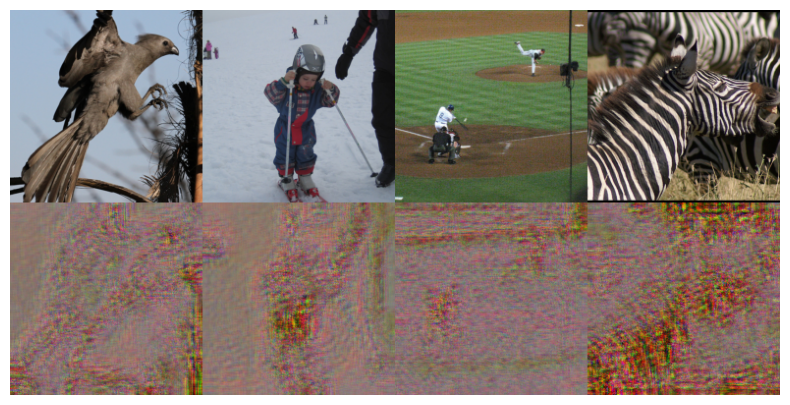

  2%|▏         | 499/29572 [00:41<39:14, 12.35it/s]

========Iteration 501========
	Content Loss:	5.0609
	Style Loss:	0.1065
	Variation Loss:	0.0009
	Clip Loss:	0.0016
	Color Loss:	0.0001
	Mse Loss:	0.0809
	Total Loss:	5.2508
Saved TransformerNetwork checkpoint file at models/spaghetti256_a75/model/checkpoint.pth
Saved sample transformed image at models/spaghetti256_a75/images/sample_501.png


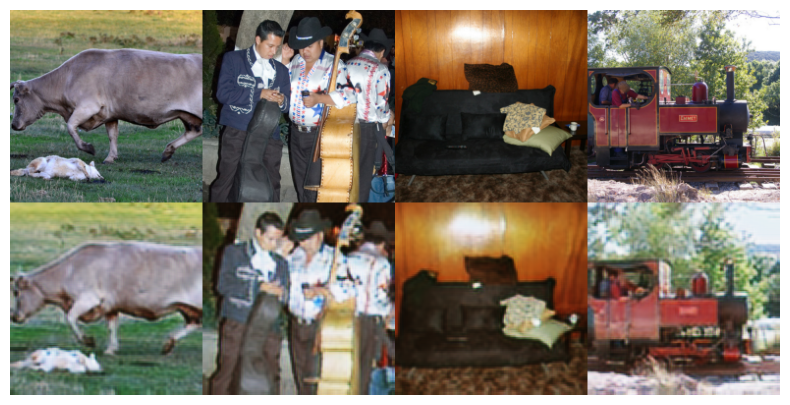

  3%|▎         | 1000/29572 [02:07<1:36:02,  4.96it/s]

========Iteration 1001========
	Content Loss:	7.4755
	Style Loss:	3.3407
	Variation Loss:	0.1320
	Clip Loss:	0.4444
	Color Loss:	0.0584
	Mse Loss:	0.2764
	Total Loss:	11.7275
Saved TransformerNetwork checkpoint file at models/spaghetti256_a75/model/checkpoint.pth
Saved sample transformed image at models/spaghetti256_a75/images/sample_1001.png


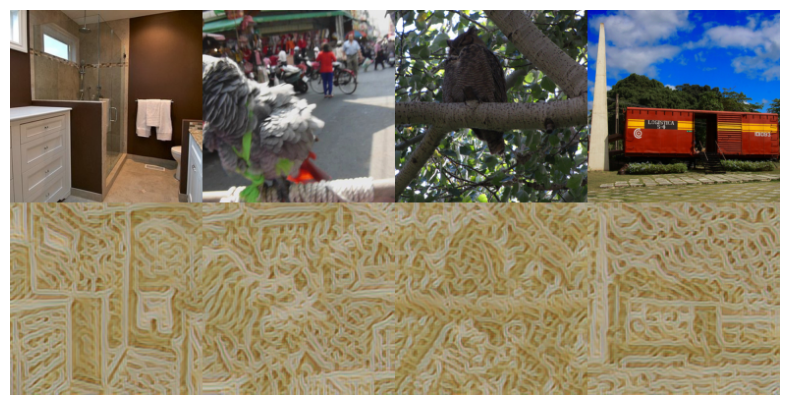

  4%|▍         | 1324/29572 [03:18<1:46:47,  4.41it/s]

In [ ]:
# cell 7: Training loop
optimizer = optim.Adam(TransformerNetwork.parameters(), lr=ADAM_LR)
batch_count = 0
losses_sum = {'content': 0, 'style': 0, 'variation': 0, 'clip': 0, 'color': 0, 'mse': 0}

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    for content_batch, _ in tqdm(train_loader):
        batch_count += 1
        content_batch = content_batch[:, [2, 1, 0]].to(device)
        optimizer.zero_grad()

        generated_batches = TransformerNetwork.forward_multiscale(content_batch)

        total_loss, loss_components = compute_loss(
            content_batch, generated_batches, VGG, CLIP_NET, transform_clip, pretrain=(batch_count < PRETRAIN_BATCHES)
        )

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(TransformerNetwork.parameters(), 2)
        optimizer.step()

        for k in losses_sum.keys():
            if k in loss_components:
                losses_sum[k] += loss_components[k].item()

        # Logging and saving every SAVE_MODEL_EVERY iterations
        if ((batch_count - 1) % SAVE_MODEL_EVERY == 0) or (batch_count == NUM_EPOCHS * len(train_loader)):
            utils.log_losses(batch_count, losses_sum)
            utils.save_outputs(batch_count, content_batch, generated_batches[0], TransformerNetwork, SAVE_MODEL_PATH, SAVE_IMAGE_PATH)

